In [1]:
import sys, os, itertools, sklearn
sys.path.append('/home/roquero/CausalAggregation/Code')
import pandas as pd
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LassoCV, Lasso
from sklearn import datasets
from sklearn.metrics import auc
from scipy.interpolate import UnivariateSpline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%reload_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}, linewidth=100000)
from backfitting import Backfitting
from base_environment import BaseEnvironment
from collection_environment import CollectionEnvironment
from regression_method import PolynomialRegression, RandomForestRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


/home/roquero/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [16]:
ik_h, se_h = [], (lambda input_samples:input_samples)
ik_x1, se_x1 = ['h'], (lambda input_samples: 2*input_samples[0] + input_samples[1])
ik_x2, se_x2 = ['h', 'x1'], (lambda input_samples: input_samples[0] + input_samples[1] + input_samples[2])
ik_x3, se_x3 = ['x1', 'x2'], (lambda input_samples: -input_samples[0] + 2*input_samples[1] + input_samples[2])
ik_x4, se_x4 = ['x1', 'x3'], (lambda input_samples: np.log(1+np.abs(input_samples[0])) + input_samples[1] + input_samples[2])
ik_y, se_y = ['h','x1','x2','x3','x4'], (lambda input_samples:
                                         input_samples[0] 
                                         + input_samples[1]**2
                                         #+ 0.5*input_samples[1]*input_samples[2]
                                         + 0.5*input_samples[1]*input_samples[2]*input_samples[3]
                                         - 0.5*input_samples[3]*input_samples[4]
                                         + input_samples[2]*input_samples[4] + 0*input_samples[5])
ik_x5, se_x5 = ['x2', 'x4', 'y'], (lambda input_samples: 2*input_samples[0] + input_samples[1] - input_samples[2] + input_samples[3])

In [17]:
fh = {'input_keys':ik_h, 'structural_eq': se_h}
f1 = {'input_keys':ik_x1, 'structural_eq': se_x1}
f2 = {'input_keys':ik_x2, 'structural_eq': se_x2}
f3 = {'input_keys':ik_x3, 'structural_eq': se_x3}
f4 = {'input_keys':ik_x4, 'structural_eq': se_x4}
f5 = {'input_keys':ik_x5, 'structural_eq': se_x5}
fy = {'input_keys':ik_y, 'structural_eq': se_y}

sh = lambda n_samples: np.random.normal(size=n_samples)
s1 = lambda n_samples: np.random.normal(size=n_samples)
s2 = lambda n_samples: np.random.normal(size=n_samples)
s3 = lambda n_samples: np.random.normal(size=n_samples)
s4 = lambda n_samples: np.random.normal(size=n_samples)
s5 = lambda n_samples: np.random.normal(size=n_samples)
sy = lambda n_samples: np.random.normal(size=n_samples)

topo_order = ['h','x1','x2','x3','x4','y','x5']
y_key = 'y'
x_key = ['x1','x2','x3','x4','x5']

structural_equation_dict = {'x1':f1, 'x2':f2, 'x3':f3, 'y':fy, 'x4':f4, 'x5':f5, 'h':fh}
disturbance_sampler_dict = {'x1':s1, 'x2':s2, 'x3':s3, 'y':sy, 'x4':s4, 'x5':s5, 'h':sh}

base = BaseEnvironment(structural_equation_dict, disturbance_sampler_dict, topo_order, y_key, x_key)
coll_env = CollectionEnvironment(base)

coll_env.add_env('e1', {'x1':{'type':'independent'},'x2':{'type':'independent'}, 'x3':{'type':'independent'}}, 10000)
coll_env.add_env('e2', {'x2':{'type':'independent'},'x4':{'type':'independent'}}, 10000)
coll_env.add_env('e3', {'x4':{'type':'independent'},'x3':{'type':'independent'}}, 10000)
coll_env.add_env('e4', {'x1':{'type':'independent'},'x5':{'type':'independent'}}, 10000)

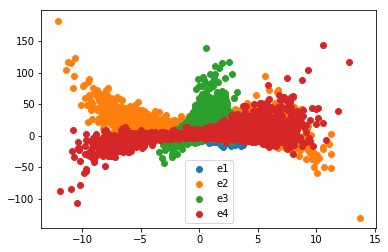

In [19]:
for key in coll_env.env.keys():
    _ = plt.scatter(coll_env.env[key].data['X'][2,:],coll_env.env[key].data['Y'][:], label=str(key))
_ = plt.legend()

In [29]:
params_method = {'regression_method':'HuberRegressor',
                 'power_features': {
                     'e1':3,
                     'e2':2,
                     'e3':2,
                     'e4':2,
                     'e5':2,
                                     },
                 'selected_features':{
                     #'e1':['1','x1^0', 'x2^0','x2^2',  'x3^0', 'x1^0x2^0', 'x1^0x3^0',  'x2^0x3^0', 'x3^2', 'x1^3',
                     #      'x1^2x2^0', 'x1^2x3^0', 'x1^0x2^2', 'x1^0x3^2', 'x2^3', 'x2^2x3^0', 'x2^0x3^2', 'x3^3'],
                     'e1':['1','x1^0', 'x2^0','x2^2',  'x3^0', 'x1^2', 'x1^0x2^0', 'x1^0x3^0',  'x2^0x3^0', 'x3^2', 'x1^3',
                           'x1^2x2^0', 'x1^2x3^0', 'x1^0x2^2', 'x1^0x2^0x3^0', 'x1^0x3^2', 'x2^3', 'x2^2x3^0', 'x2^0x3^2', 'x3^3'],
                     'e2':['x2^0x4^0'],
                     'e3':['x3^0x4^0'],
                     'e4':['x1^0x5^0'],
                 },
                 'n_estimators':20
                }

backfit = Backfitting(PolynomialRegression, 
                      'boosting',
                      max_n_iter=20,
                      gap_convergence=1e-5,
                      warm_start=False, 
                      params_method=params_method,
                      reweighting_candidates=True,
                      update_within_loop=False,
                     true_y_coeff={'x1^2':1, 'x1^0x2^0x3^0':0.5, 'x3^0x4^0':-0.5, 'x2^0x4^0':1})

                     
res = backfit.fit(coll_env)
print('Reconstruction loss', res[0])
print('Validation loss', res[1])

 10%|█         | 2/20 [00:00<00:01,  9.55it/s]

reweighting values [0.619 14.338 0.867 0.249] 1.7763568394002505e-13


 15%|█▌        | 3/20 [00:00<00:02,  6.06it/s]

reweighting values [1.056 1.541 0.431 1.998] -1.8050524454044786e-12


 20%|██        | 4/20 [00:00<00:03,  4.68it/s]

reweighting values [0.808 1.303 8.655 -1.082] -5.122698934475681e-15


 25%|██▌       | 5/20 [00:01<00:03,  3.92it/s]

reweighting values [0.848 0.073 -0.073 0.043] 1.7947329015535773e-15


 30%|███       | 6/20 [00:01<00:04,  3.37it/s]

reweighting values [0.082 -0.001 -0.000 0.001] 2.4034559878340772e-20


 35%|███▌      | 7/20 [00:01<00:04,  2.98it/s]

reweighting values [-0.000 0.000 0.000 -0.000] 1.44524996625265e-20


 40%|████      | 8/20 [00:02<00:04,  2.61it/s]

reweighting values [-0.002 0.000 0.000 -0.000] 1.1752582143153417e-20


 45%|████▌     | 9/20 [00:02<00:03,  2.78it/s]

reweighting values [-0.000 0.000 0.000 -0.000] -2.6469779601696886e-23


 50%|█████     | 10/20 [00:03<00:04,  2.35it/s]

reweighting values [-0.000 0.000 0.000 -0.000] -5.955700410381799e-23


 55%|█████▌    | 11/20 [00:03<00:04,  2.08it/s]

reweighting values [0.000 -0.000 -0.000 0.000] 2.150669592637872e-22


 60%|██████    | 12/20 [00:04<00:04,  1.78it/s]

reweighting values [-0.000 0.000 0.000 -0.000] 8.271806125530277e-25


 65%|██████▌   | 13/20 [00:05<00:04,  1.65it/s]

reweighting values [0.000 -0.000 -0.000 0.000] 7.031035206700735e-24


 70%|███████   | 14/20 [00:06<00:03,  1.53it/s]

reweighting values [-0.000 0.000 0.000 -0.000] -2.0679515313825692e-25


 75%|███████▌  | 15/20 [00:06<00:03,  1.39it/s]

reweighting values [0.000 -0.000 -0.000 0.000] -1.0339757656912846e-25


 80%|████████  | 16/20 [00:07<00:03,  1.32it/s]

reweighting values [-0.000 0.000 0.000 -0.000] 9.305781891221561e-25


 85%|████████▌ | 17/20 [00:08<00:02,  1.23it/s]

reweighting values [0.000 -0.000 -0.000 0.000] 4.1359030627651384e-25


 90%|█████████ | 18/20 [00:09<00:01,  1.17it/s]

reweighting values [-0.000 0.000 0.000 -0.000] -2.0679515313825692e-25


 95%|█████████▌| 19/20 [00:10<00:00,  1.09it/s]

reweighting values [0.000 -0.000 -0.000 0.000] 6.462348535570529e-27


100%|██████████| 20/20 [00:11<00:00,  1.04it/s]

reweighting values [-0.000 0.000 0.000 -0.000] -4.8467614016778965e-26


100%|██████████| 20/20 [00:12<00:00,  1.54it/s]

reweighting values [0.000 -0.000 -0.000 0.000] -8.077935669463161e-28
Reconstruction loss 31.350181387475615
Validation loss 4.357787236454649


In [30]:
poly = PolynomialFeatures(
                degree=3
                )
x = poly.fit_transform(backfit.x_train_full.T)
lr = Lasso(alpha=0.01)
lr.fit(x, backfit.y_train_full)
np.mean(np.square(lr.predict(poly.fit_transform(backfit.x_val_full.T))-backfit.y_val_full))
np.mean(np.square(backfit.output_function_merged(backfit.x_val_full)-backfit.true_function_y(backfit.x_val_full)))

/home/roquero/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7266.162381290206, tolerance: 225.56087485941995
  positive)


Lasso(alpha=0.01)

0.48738406179690685

0.8042037948395578

(array([1.000, 1.000, 0.000, 1.000, 1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 1.000, 1.000, 0.000, 0.000, 3.000, 0.000, 1.000, 1.000, 0.000, 0.000, 2.000, 1.000, 0.000, 1.000, 1.000, 0.000, 2.000, 2.000, 3.000, 4.000, 3.000, 3.000, 7.000, 2.000, 7.000, 6.000, 7.000, 10.000, 19.000, 18.000, 24.000, 35.000, 37.000, 46.000, 76.000, 100.000, 149.000, 282.000, 835.000, 5028.000, 665.000, 202.000, 113.000, 66.000, 41.000, 32.000, 26.000, 22.000, 16.000, 14.000, 8.000, 8.000, 8.000, 11.000, 5.000, 7.000, 6.000, 2.000, 1.000, 2.000, 5.000, 3.000, 1.000, 3.000, 1.000, 1.000, 0.000, 2.000, 1.000, 0.000, 0.000, 2.000, 0.000, 0.000, 0.000, 0.000, 0.000, 2.000, 0.000, 0.000, 1.000, 0.000, 0.000, 0.000, 0.000, 1.000, 0.000, 0.000, 1.000]),
 array([-12.873, -12.618, -12.363, -12.109, -11.854, -11.599, -11.344, -11.090, -10.835, -10.580, -10.325, -10.071, -9.816, -9.561, -9.306, -9.052, -8.797, -8.542, -8.288, -8.033, -7.778, -7.523, -7.269, -7.014, -6.759, -6.504, -6.250, -5.995, -5.740, -5.48

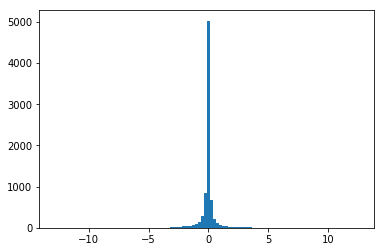

In [22]:
plt.hist(backfit.output_function_merged(backfit.x_val_full)-backfit.true_function_y(backfit.x_val_full), bins=100)

(array([2.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 1.000, 1.000, 0.000, 0.000, 0.000, 0.000, 1.000, 1.000, 1.000, 3.000, 2.000, 2.000, 5.000, 2.000, 2.000, 9.000, 3.000, 2.000, 10.000, 8.000, 8.000, 8.000, 12.000, 16.000, 14.000, 17.000, 19.000, 29.000, 20.000, 26.000, 38.000, 41.000, 44.000, 49.000, 67.000, 81.000, 88.000, 107.000, 141.000, 123.000, 165.000, 207.000, 263.000, 268.000, 393.000, 430.000, 512.000, 509.000, 570.000, 506.000, 485.000, 441.000, 360.000, 297.000, 277.000, 192.000, 167.000, 143.000, 118.000, 98.000, 82.000, 63.000, 54.000, 41.000, 39.000, 41.000, 41.000, 33.000, 26.000, 17.000, 24.000, 18.000, 13.000, 14.000, 12.000, 10.000, 14.000, 7.000, 8.000, 12.000, 6.000, 5.000, 1.000, 2.000, 4.000, 1.000, 3.000, 0.000, 0.000, 1.000, 2.000, 1.000, 1.000]),
 array([-4.393, -4.314, -4.235, -4.155, -4.076, -3.997, -3.918, -3.839, -3.759, -3.680, -3.601, -3.522, -3.442, -3.363, -3.284, -3.205, -3.126, -3.046, -2.967, -2.888, -2.809, -2.730, -2.650, -2.571, -2.492, -2.

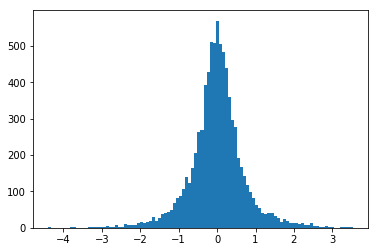

In [23]:
plt.hist(lr.predict(poly.fit_transform(backfit.x_val_full.T))-backfit.true_function_y(backfit.x_val_full), bins=100)

In [24]:
(backfit.output_function_merged(backfit.x_val_full)-backfit.true_function_y(backfit.x_val_full))
(lr.predict(poly.fit_transform(backfit.x_val_full.T))-backfit.true_function_y(backfit.x_val_full))

array([0.005, -0.110, 0.020, ..., 0.148, 2.046, 0.002])

array([0.174, 0.018, -0.025, ..., 0.879, 1.447, -0.259])

In [25]:
lr.predict(poly.fit_transform(backfit.x_val_full.T))
backfit.output_function_merged(backfit.x_val_full)
backfit.y_val_full
backfit.true_function_y(backfit.x_val_full)

array([0.180, -1.270, 1.923, ..., -0.308, 5.925, -0.454])

array([0.011, -1.398, 1.969, ..., -1.039, 6.524, -0.192])

array([0.419, -0.625, 0.928, ..., 0.984, 5.524, -0.159])

array([0.006, -1.288, 1.949, ..., -1.186, 4.478, -0.194])

In [26]:
backfit.evaluate_val()

1.448999077852359

In [13]:

backfit.y_val_full

array([0.878, -0.436, -5.023, ..., 0.063, 1.858, -8.945])